<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 2*

# Document Representations: Bag-Of-Words

In [1]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Requirement already up-to-date: nltk in /anaconda3/lib/python3.7/site-packages (3.4.4)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/connorheraty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorheraty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
df = pd.read_csv('job_listings.csv')

## 2) Use Spacy to tokenize / clean the listings 

In [7]:
import spacy
nlp = spacy.load('en')

In [111]:
#df['description'] = df['description'].map(lambda x: x.strip('<>"/\|'))

In [55]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(df['description'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

In [56]:
df['tokens'] = tokens

In [57]:
df.head()

,Unnamed: 0,description,title,tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"[b""<div><div>job, requirements:</div><ul><li><..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"[b'<div>job, description<br/>\n<br/>\n<p>as, a..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,"[b'<div><p>as, a, data, scientist, you, will, ..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"[b'<div, class=""jobsearch-jobmetadataheader, i..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,"[b'<ul><li>location:, usa, \xe2\x80\x93, multi..."


# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
#text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet."," In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma."," This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vectorizer = CountVectorizer(stop_words='english', lowercase=False, tokenizer=lambda x:x)

# tokenize and build vocab
vectorizer.fit_transform(df['tokens'])


# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.
vectorizer.vocabulary_

# The vocabulary dictionary does not represent the counts of words!!
dtm = vectorizer.transform(df['tokens'])

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [66]:
dtm_df = pd.DataFrame(dtm.todense(), columns=vectorizer.get_feature_names())

In [67]:
dtm_df.head()

,"""><span","""ability","""apply""","""best","""big","""can","""can-do""","""completeness","""customer","""engineering",...,zillow\'s,zones</p></li><li><p>\nability,zoom,zuckerberg,zurich,|,|</b>,||,~$70,~4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

In [27]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = list(zip(word_counts.keys(), word_counts.values()))
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = list(zip(appears_in.keys(), appears_in.values()))
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [31]:
wc = count(df)

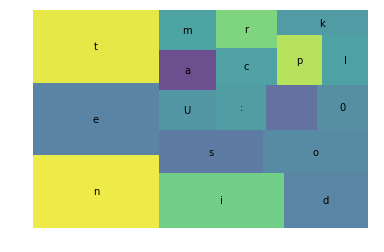

In [32]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [33]:
STOP_WORDS = nlp.Defaults.stop_words.union(['t', 'e', 'n' 'm', 'a', 'U', 's',
                                            'i', 'r', 'c', ':', 'k ', 'p',
                                           'l', '0', 'o', 'd'])

In [36]:
tokens = []

for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [39]:
wc = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
41,data,419,3748,1.0,0.028939,0.028939,0.983568
222,business,303,1008,2.0,0.007783,0.036722,0.711268
65,experience,357,940,3.0,0.007258,0.043980,0.838028
64,work,326,875,4.0,0.006756,0.050736,0.765258
280,team,314,726,5.0,0.005606,0.056342,0.737089


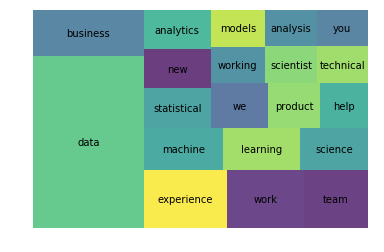

In [40]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, lowercase=False, tokenizer=lambda x:x)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['tokens'])
#dtm = tfidf.transform(new_data)

# Print word counts

# Get feature names to use as dataframe column headers

# View Feature Matrix as DataFrame
docs = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
docs.head()

,"""><span","""best",&amp;,(,(5),(a/b,(an,(and,(applies,(both,...,you\xe2\x80\x99ll,you\xe2\x80\x99re,you\xe2\x80\x99ve,young,zf,zf\xe2\x80\x99s,zillow,|,|</b>,||
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.035205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.076882,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 # 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [72]:
# Instantiate
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# Fit on TF-IDF Vectors
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [73]:
# Query Using kneighbors 
nn.kneighbors(dtm.todense()[0])

(array([[0.        , 1.3045984 , 1.33167367, 1.33220172, 1.33252667]]),
 array([[  0, 115, 325, 338, 276]]))

In [76]:
# Text describing my ideal Data Science position
new = tfidf.transform(['Data Science position that uses machine learning techniques to solve unique business problems'])

nn.kneighbors(new.todense())

(array([[1.300574  , 1.35000462, 1.38152777, 1.40054188, 1.40233551]]),
 array([[390,  79, 411,  19, 384]]))

In [80]:
df['description'][79]

'b\'<div class="jobsearch-JobMetadataHeader icl-u-xs-mb--md"><div class="jobsearch-JobMetadataHeader-item icl-u-xs-mt--xs">Contract</div></div><div>Akraya is looking for a <b>Data Scientist </b>for one of our clients. If the job description below is a fit, please apply directly or call <b>Swapnil </b>at<b> 408-907-3201</b>. If this position is not quite what you\\xe2\\x80\\x99 re looking for, visit akraya.Com and submit a copy of your resume. Our recruiters will get to work finding you a job that is a better match at one of our many clients.<br/>\\n<br/>\\n<b>Primary Skills: </b><b>Data Science, Hive/Impala/Hadoop, </b><b>Statistical and Data Mining, R, Python, Redshift/ S3/ Spark, Google Analytics/ Adwords</b><br/>\\n<b>Duration:</b><b> 6+ Months, with possible extension</b><br/>\\n<b>Contract Type:</b><b> W2 Only</b><br/>\\n<br/>\\n<b>Top Daily Responsibilities:</b>\\n<ul><li>Knowledge and experience with large data sets, event streams and distributed computing (Hive/Impala/Hadoop et

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.